In [1]:
import os
import numpy as np
import nibabel as nib
import h5py
import time
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
np.__version__

'1.14.3'

In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [4]:
brain_path = os.path.join(dataset_path, 'fly_143', 'func_0', 'imaging', 'functional_channel_2_moco_zscore_highpass.h5')
with h5py.File(brain_path, 'r+') as h5_file:
    brain = h5_file.get("data")
    print(brain.shape)
#brain.shape

(256, 128, 49, 3384)


In [12]:
brain_path = os.path.join(dataset_path, 'fly_143', 'func_0', 'functional_channel_2_moco_zscore_highpass.h5')
with h5py.File(brain_path, 'r+') as h5_file:
    brain = h5_file.get("data")[:,:,20,:].astype('float32')
brain.shape

(256, 128, 3384)

In [38]:
brain_path = os.path.join(dataset_path, 'fly_143', 'func_0', 'imaging', 'functional_channel_2_mean.nii')
meanbrain = np.asarray(nib.load(brain_path).get_data().squeeze(), dtype='float32')
meanbrain.shape

(256, 128, 49)

In [24]:
meanbrain_thresh = np.copy(meanbrain)
meanbrain_thresh[np.where(meanbrain < 500)] = 0

In [42]:
mask = np.zeros((256,128))
mask[np.where(meanbrain[:,:,20] > 500)] = 1

In [63]:
from scipy.ndimage.morphology import binary_erosion

In [71]:
mask_eroded = binary_erosion(mask, structure=np.ones((10,10)))

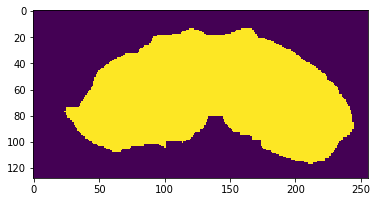

In [72]:
plt.imshow(mask_eroded.T)

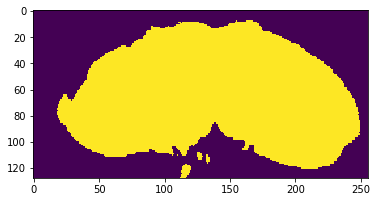

In [62]:
plt.imshow(mask.T)

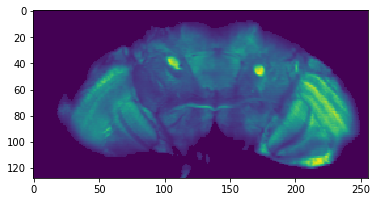

In [31]:
plt.imshow(meanbrain_thresh[:,:,20].T)

In [71]:
corr_path = os.path.join(dataset_path, 'fly_143', 'func_0', 'corr', '20220420_corr_dRotLabY.nii')
corr = np.asarray(nib.load(corr_path).get_data().squeeze(), dtype='float32')
corr.shape

NameError: name 'nib' is not defined

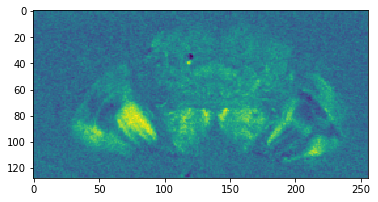

In [23]:
plt.imshow(corr[:,:,20].T)

In [44]:
mask.shape, brain.shape

((256, 128), (256, 128, 3384))

In [46]:
brain_masked = brain*mask[:,:,np.newaxis]

In [73]:
brain_masked = brain*mask_eroded[:,:,np.newaxis]

In [47]:
brain_masked.shape

(256, 128, 3384)

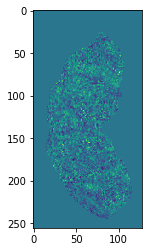

In [74]:
plt.imshow(brain_masked[:,:,0])

In [75]:
z=20
neural_activity = brain_masked.reshape(-1, 3384)
neural_activity.shape

(32768, 3384)

In [76]:
cluster_dir = os.path.join(dataset_path, 'fly_143', 'func_0', 'clustering')
#os.mkdir(cluster_dir)

In [77]:
n_clusters = 2000
t0 = time.time()

connectivity = grid_to_graph(256,128)
cluster_model = AgglomerativeClustering(n_clusters=n_clusters,
                                memory=cluster_dir,
                                linkage='ward',
                                connectivity=connectivity)
cluster_model.fit(neural_activity)
print('Duration: {}'.format(time.time()-t0))

Duration: 7.599117755889893


/home/users/brezovec/.local/lib/python3.6/site-packages/sklearn/cluster/_hierarchical.py:856: UserWarning: Persisting input arguments took 0.73s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **kwargs)


In [78]:
cluster_model_labels = cluster_model.labels_

In [79]:
colored = cluster_model.labels_.reshape(256,128).astype('float')
colored.shape

(256, 128)

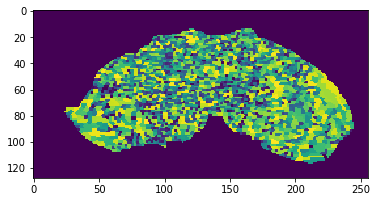

In [80]:
plt.imshow(colored.T)

In [81]:
signals = []
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    mean_signal = np.mean(neural_activity[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
cluster_signals=np.asarray(signals)

In [82]:
cluster_signals.shape

(2000, 3384)

In [83]:
save_file = os.path.join(cluster_dir, 'slice_20_cluster_labels.npy')
np.save(save_file, cluster_model_labels)
#cluster_model_labels = np.load(save_file)

In [84]:
save_file = os.path.join(cluster_dir, 'slice_20_cluster_signals.npy')
np.save(save_file, cluster_signals)
#cluster_signals = np.load(save_file)

# Network analysis

In [42]:
n_clusters = 2000

In [28]:
from sknetwork.clustering import Louvain
from sklearn.covariance import GraphicalLassoCV
from sknetwork.visualization import svg_graph

In [29]:
cluster_signals.shape

(2000, 3384)

In [30]:
corr_matrix = np.corrcoef(cluster_signals)

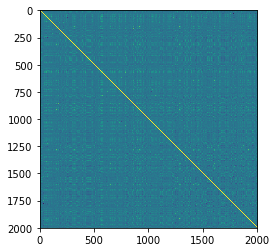

In [31]:
plt.imshow(corr_matrix)

In [32]:
#idk why this but copying from
#https://stackoverflow.com/questions/58384552/how-to-estimate-network-structure-from-weighted-adjacency-matrix-using-sklearn
corr_matrix = (corr_matrix+1)/2 


In [34]:
np.fill_diagonal(corr_matrix, 0)

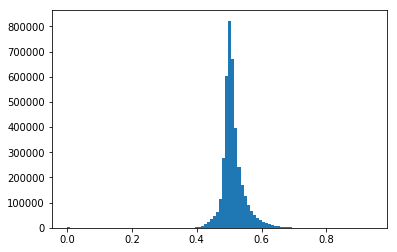

In [51]:
plt.hist(corr_matrix.flatten(),bins=100);

In [54]:
corr_matrix_thresh

<function ndarray.copy>

In [62]:
corr_matrix_thresh = np.copy(corr_matrix)
corr_matrix_thresh[np.where(corr_matrix < .5)]=0


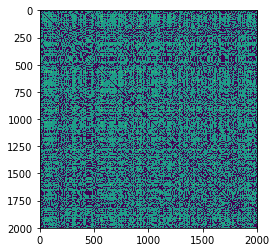

In [63]:
plt.imshow(corr_matrix_thresh)

In [64]:
louvain = Louvain()

In [65]:
labels = louvain.fit_transform(corr_matrix_thresh)

In [66]:
len(set(labels))

4

In [67]:
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = labels[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

In [68]:
colored_by_betas.shape

(256, 128)

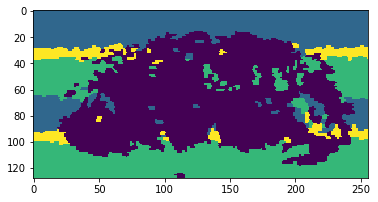

In [69]:
plt.imshow(colored_by_betas.T)